In [1]:
# Step 1: Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Step 2: Load Data
df = pd.read_excel("E Commerce Dataset.xlsx", sheet_name="E Comm")
df.head()


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [6]:
# Step 3: Preprocessing

# Drop ID column if present
df.drop(columns=['CustomerID'], inplace=True, errors='ignore')

# Fill missing numerical values with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing categorical values with mode
cat_cols = df.select_dtypes(include='object').columns
# Safe fill for missing categorical values
for col in cat_cols:
    if df[col].isnull().all():
        df[col] = df[col].fillna("Unknown")
    else:
        df[col] = df[col].fillna(df[col].mode()[0])


# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Separate features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Normalize numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Double-check for any NaNs
print("NaNs after preprocessing:", X_scaled.isnull().sum().sum())


NaNs after preprocessing: 0


In [7]:
# Step 4: Train/Test Split
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Normalize numeric values
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Apply SMOTE after ensuring no NaNs
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)


# Final split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [8]:
# Combine X and y for joint EDA
df_resampled = X_res.copy()
df_resampled["Churn"] = y_res


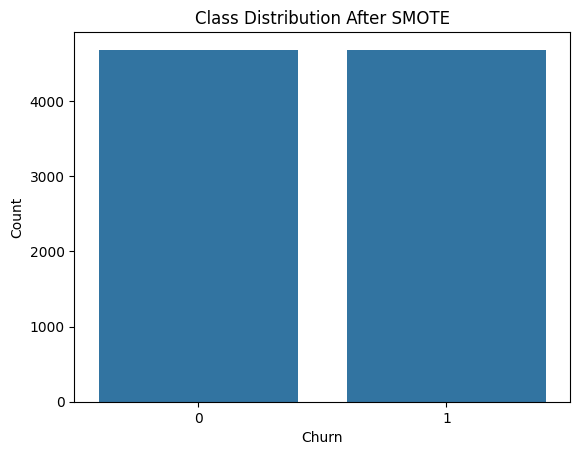

In [9]:
#Step 5 : EDA  Class Distribution After SMOTE
sns.countplot(x="Churn", data=df_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()


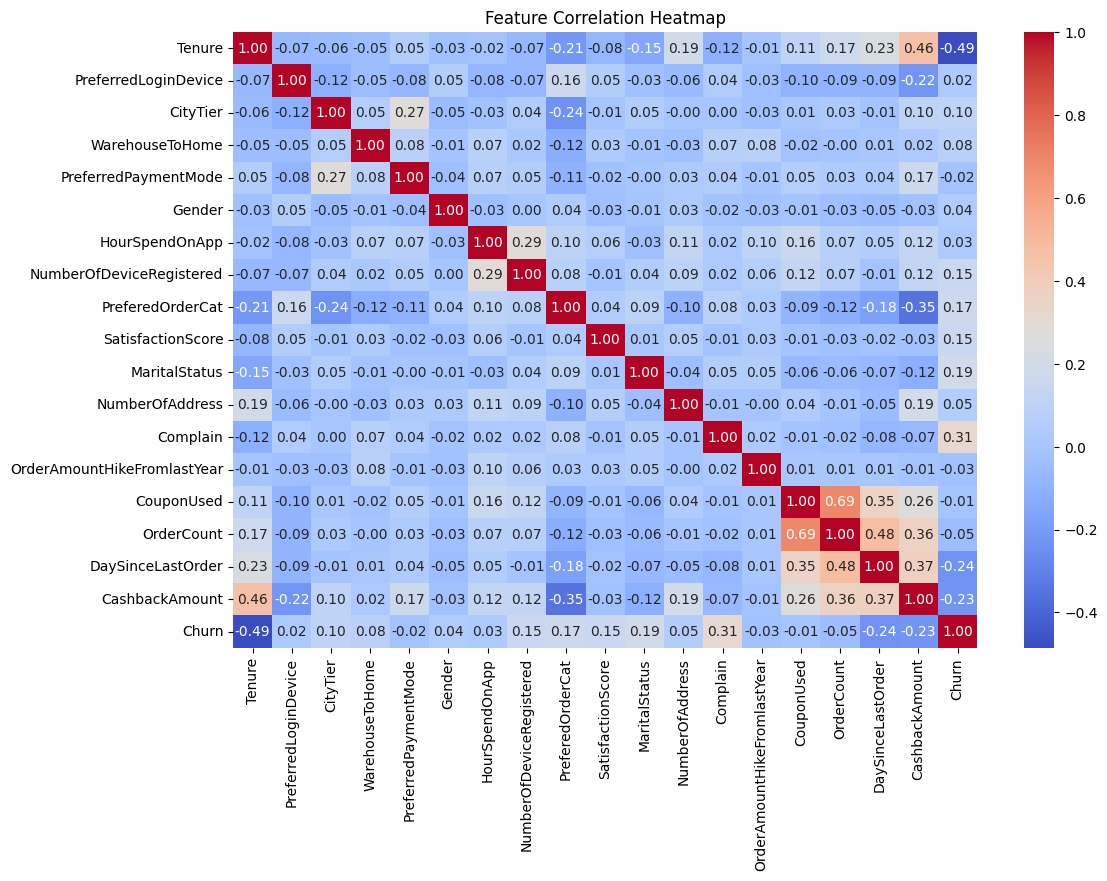

In [10]:
# Feature Correlation Heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(df_resampled.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


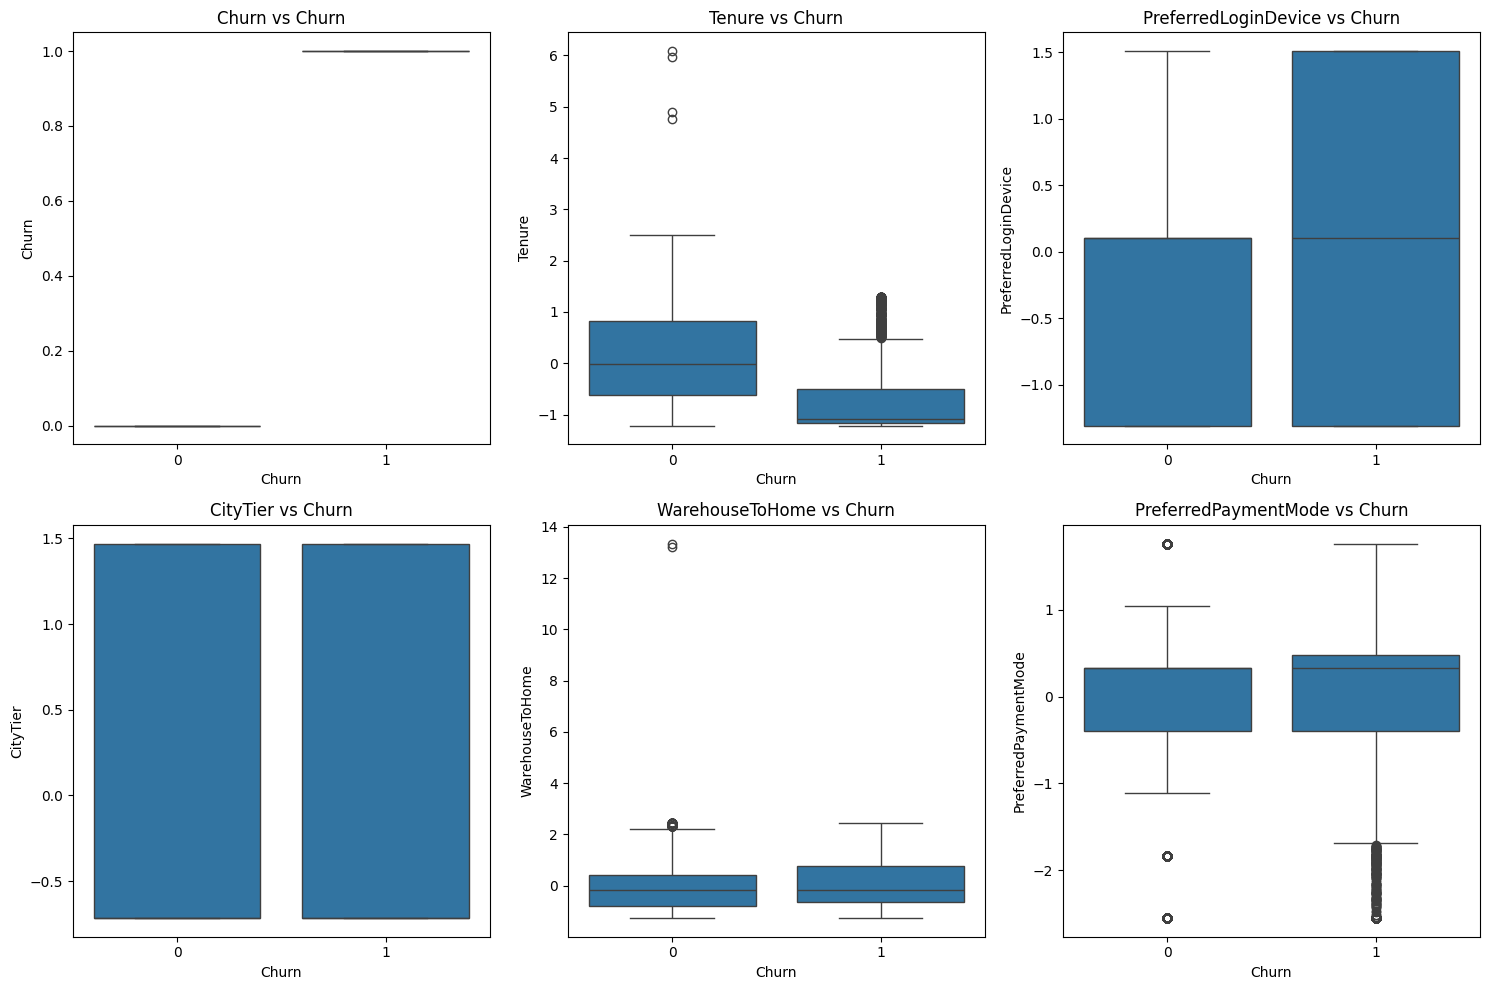

In [12]:
# Boxplots for Outlier Detection

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x="Churn", y=col, data=df_resampled)
    plt.title(f"{col} vs Churn")
plt.tight_layout()
plt.show()


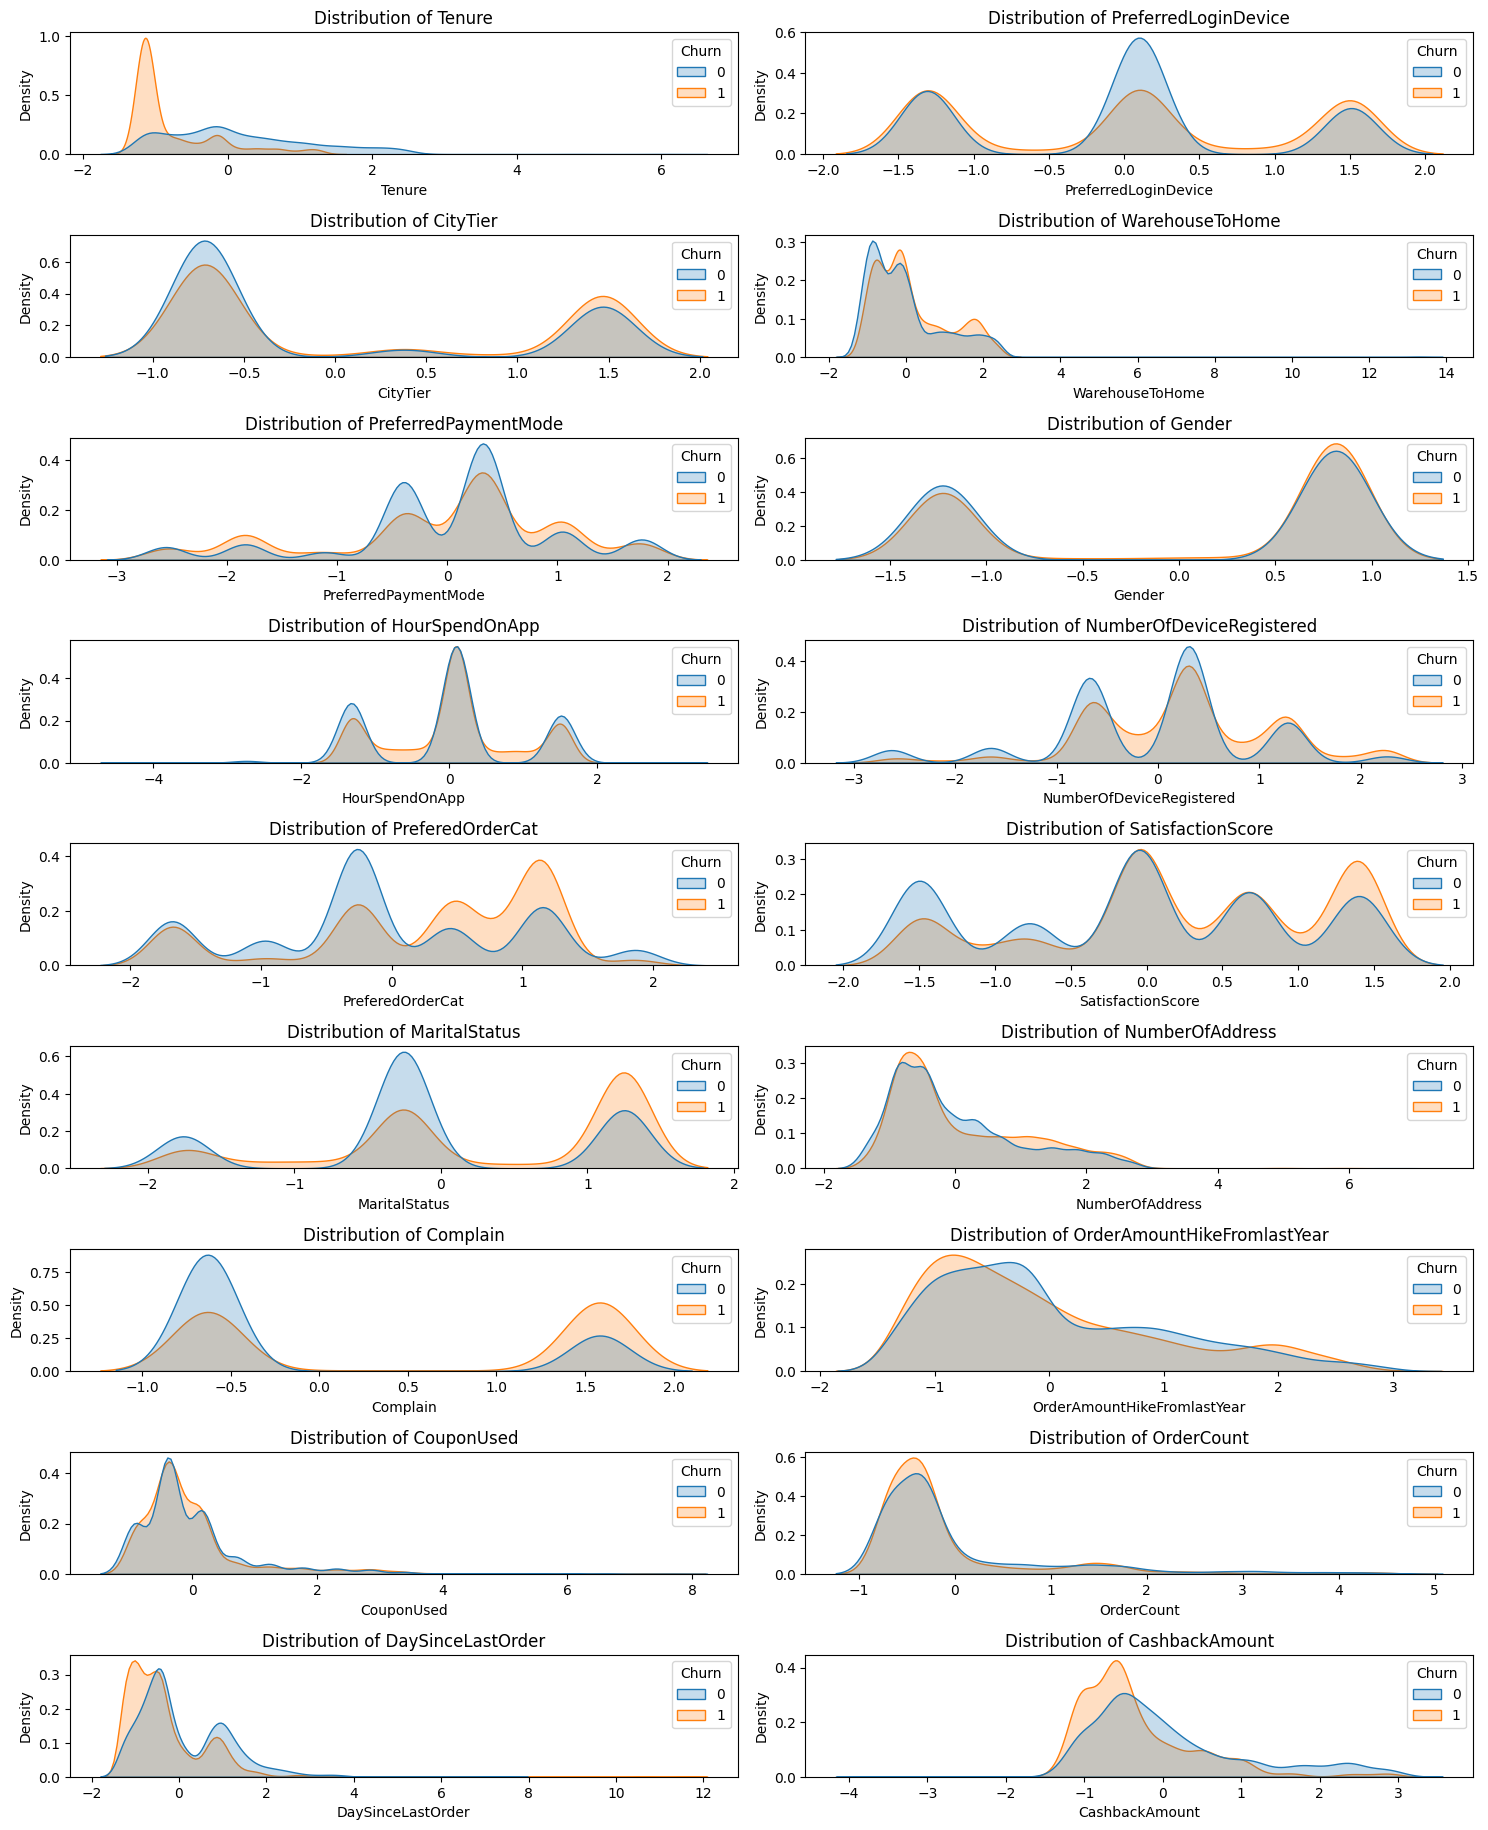

In [13]:
#Distribution Plots (Numerical Features)
import matplotlib.gridspec as gridspec

num_cols = X.columns
fig = plt.figure(figsize=(15, 20))
grid = gridspec.GridSpec(len(num_cols)//2 + 1, 2)

for i, col in enumerate(num_cols):
    ax = fig.add_subplot(grid[i])
    sns.kdeplot(data=df_resampled, x=col, hue="Churn", fill=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


📊 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       939
           1       0.78      0.81      0.79       934

    accuracy                           0.79      1873
   macro avg       0.79      0.79      0.79      1873
weighted avg       0.79      0.79      0.79      1873



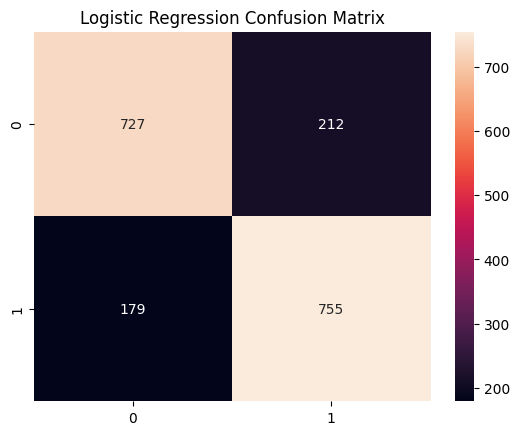

In [15]:
# Step 6: Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()


🌲 Decision Tree Results:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       939
           1       0.84      0.82      0.83       934

    accuracy                           0.83      1873
   macro avg       0.83      0.83      0.83      1873
weighted avg       0.83      0.83      0.83      1873



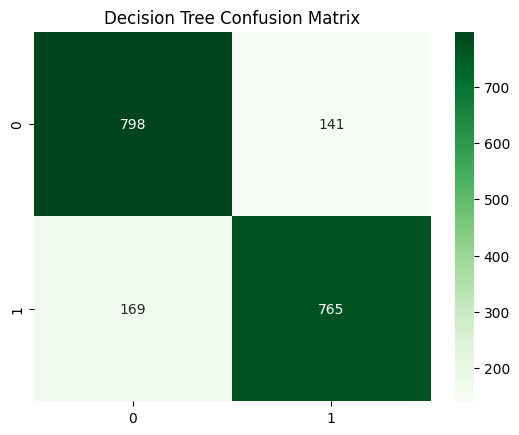

In [16]:
# Step 7: Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Results:")
print(classification_report(y_test, y_pred_dt))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap="Greens")
plt.title("Decision Tree Confusion Matrix")
plt.show()
